In [1]:
using OrdinaryDiffEq
using ModelingToolkit
using DataDrivenDiffEq
using LinearAlgebra, DiffEqSensitivity, Optim
using DiffEqFlux, Flux
using Plots
gr()

┌ Info: Precompiling DataDrivenDiffEq [2445eb08-9709-466a-b3fc-47e12bd697a2]
└ @ Base loading.jl:1260
┌ Info: Precompiling DiffEqSensitivity [41bf760c-e81c-5289-8e54-58b1f1f8abe2]
└ @ Base loading.jl:1260
┌ Info: Precompiling DiffEqFlux [aae7a2af-3d4f-5e19-a356-7da93b79d9d0]
└ @ Base loading.jl:1260


Plots.GRBackend()

## Generate The (Noisy) Training Dataset

In [181]:
function Hopf2D(du, u, p, t)
    μ, ω, A = p
    du[1] = μ*u[1] - ω*u[2] - A*u[1]*(u[1]^(2) + u[2]^(2))
    du[2] = μ*u[2] + ω*u[1] - A*u[2]*(u[1]^(2) + u[2]^(2))
end


# Define the experimental parameter

tspan = (0.0f0, 2.0f0)
u0 = Float32[-0.2, 0.2]
p_ = Float32[0.8, 1.2, 1.5]

prob = ODEProblem(Hopf2D, u0,tspan, p_)

solution = solve(prob, Vern7(), abstol=1e-12, reltol=1e-12, saveat = 0.05)


X = Array(solution)

# Add noise to the data
println("Generate noisy data")
Xₙ = X + Float32(1e-4)*randn(eltype(X), size(X));

Generate noisy data


## Plot The Training Dataset

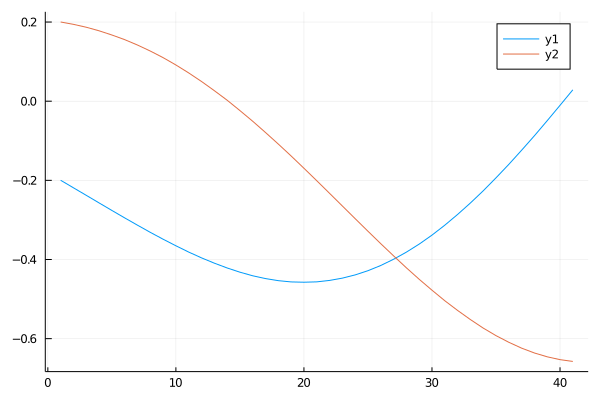

In [182]:
#plot(solution)
#plot(Array(solution)[1, :], Array(solution)[2, :])
#plot(Xₙ[1, :], Xₙ[2, :])
plot(Xₙ[1, :])
plot!(Xₙ[2, :])

## UADE

In [183]:
# Neural network

L = FastChain(FastDense(2, 32, tanh), FastDense(32, 32, tanh), FastDense(32, 32, tanh), FastDense(32, 2))
p = initial_params(L)


# ODE

function dudt_(u, p, t)
    x, y = u
    z = L(u,p)
    [p_[1]*x - p_[2]*y - p_[3]*z[1],
    p_[2]*x + p_[1]*y - p_[3]*z[2]]
end

# ODE problem

prob_nn = ODEProblem(dudt_, u0, tspan, p)
sol_nn = solve(prob_nn, Tsit5(), u0 = u0, p = p, saveat = 0.05);

## PLot The Untrained Solution

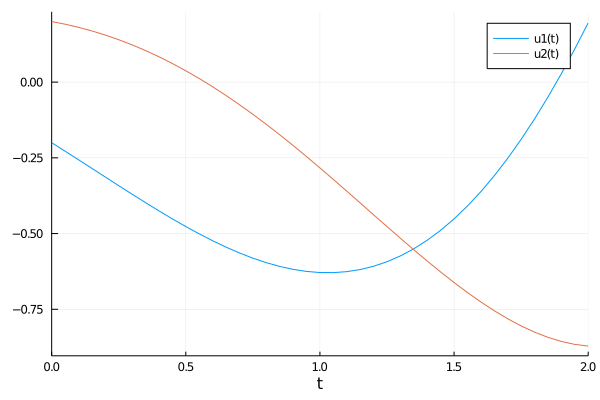

In [184]:
plot(sol_nn)
#plot(Array(sol_nn)[1, :], Array(sol_nn)[2, :])

## Loss Function

In [185]:
# This function is used in the loss
function predict(θ)
    Array(solve(prob_nn, Vern7(), u0 = u0, p=θ, saveat = 0.05,
                         abstol=1e-6, reltol=1e-6,
                         sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end


# No regularisation right now
function loss(θ)
    pred = predict(θ)
    sum(abs2, Xₙ .- pred)
end


# Test
#loss(p)


const losses = []

# The callback function is cb(p,args...) where the arguments are the extra returns from the loss
callback(θ, l) = begin
    push!(losses, l)
    if length(losses)%10==0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")    
    end
    
    # The callback function must return a boolean where if true, then the optimizer will prematurely end the optimization
    false
end

callback (generic function with 2 methods)

## Training With ADAM

In [186]:
# Train with ADAM
res1 = DiffEqFlux.sciml_train(loss, p, ADAM(0.01), cb=callback, maxiters = 600)

loss: 1.42:   2%|█                                      |  ETA: 0:03:29

Current loss after 10 iterations: 1.4220593


loss: 0.738:   3%|██                                    |  ETA: 0:03:24

Current loss after 20 iterations: 0.73811895


loss: 0.381:   5%|██                                    |  ETA: 0:03:22

Current loss after 30 iterations: 0.38061905


loss: 0.316:   7%|███                                   |  ETA: 0:03:18

Current loss after 40 iterations: 0.31614846


loss: 0.217:   8%|████                                  |  ETA: 0:03:08

Current loss after 50 iterations: 0.21673898


loss: 0.143:  10%|████                                  |  ETA: 0:02:55

Current loss after 60 iterations: 0.14306138


loss: 0.0766:  12%|█████                                |  ETA: 0:02:51

Current loss after 70 iterations: 0.07658125


loss: 0.0322:  13%|█████                                |  ETA: 0:02:44

Current loss after 80 iterations: 0.03219005


loss: 0.00956:  15%|██████                              |  ETA: 0:02:31

Current loss after 90 iterations: 0.009559006


loss: 0.00241:  17%|██████                              |  ETA: 0:02:21

Current loss after 100 iterations: 0.0024116102


loss: 0.000864:  18%|███████                            |  ETA: 0:02:11

Current loss after 110 iterations: 0.0008635933


loss: 0.000484:  20%|████████                           |  ETA: 0:02:03

Current loss after 120 iterations: 0.0004836515


loss: 0.000358:  22%|████████                           |  ETA: 0:01:57

Current loss after 130 iterations: 0.00035837485


loss: 0.000315:  23%|█████████                          |  ETA: 0:01:51

Current loss after 140 iterations: 0.0003154051


loss: 0.000302:  25%|█████████                          |  ETA: 0:01:45

Current loss after 150 iterations: 0.00030227937


loss: 0.000295:  27%|██████████                         |  ETA: 0:01:40

Current loss after 160 iterations: 0.00029496392


loss: 0.00029:  28%|███████████                         |  ETA: 0:01:35

Current loss after 170 iterations: 0.00028991746


loss: 0.000288:  30%|███████████                        |  ETA: 0:01:30

Current loss after 180 iterations: 0.0002883631


loss: 0.000288:  32%|████████████                       |  ETA: 0:01:27

Current loss after 190 iterations: 0.00028831043


loss: 0.000288:  33%|████████████                       |  ETA: 0:01:23

Current loss after 200 iterations: 0.0002882062


loss: 0.000288:  35%|█████████████                      |  ETA: 0:01:19

Current loss after 210 iterations: 0.00028803272


loss: 0.000288:  37%|█████████████                      |  ETA: 0:01:16

Current loss after 220 iterations: 0.00028779675


loss: 0.000288:  38%|██████████████                     |  ETA: 0:01:13

Current loss after 230 iterations: 0.00028779331


loss: 0.000288:  40%|███████████████                    |  ETA: 0:01:10

Current loss after 240 iterations: 0.000287638


loss: 0.000288:  42%|███████████████                    |  ETA: 0:01:08

Current loss after 250 iterations: 0.00028751983


loss: 0.000287:  43%|████████████████                   |  ETA: 0:01:05

Current loss after 260 iterations: 0.0002873587


loss: 0.000287:  45%|████████████████                   |  ETA: 0:01:02

Current loss after 270 iterations: 0.00028726406


loss: 0.000287:  47%|█████████████████                  |  ETA: 0:01:00

Current loss after 280 iterations: 0.0002870628


loss: 0.000287:  48%|█████████████████                  |  ETA: 0:00:57

Current loss after 290 iterations: 0.0002869547


loss: 0.000287:  50%|██████████████████                 |  ETA: 0:00:55

Current loss after 300 iterations: 0.00028669668


loss: 0.000287:  52%|███████████████████                |  ETA: 0:00:53

Current loss after 310 iterations: 0.0002866485


loss: 0.000286:  53%|███████████████████                |  ETA: 0:00:50

Current loss after 320 iterations: 0.00028647485


loss: 0.000286:  55%|████████████████████               |  ETA: 0:00:48

Current loss after 330 iterations: 0.00028638562


loss: 0.000286:  57%|████████████████████               |  ETA: 0:00:46

Current loss after 340 iterations: 0.00028621635


loss: 0.000286:  58%|█████████████████████              |  ETA: 0:00:44

Current loss after 350 iterations: 0.00028598995


loss: 0.000286:  60%|██████████████████████             |  ETA: 0:00:42

Current loss after 360 iterations: 0.0002859195


loss: 0.000286:  62%|██████████████████████             |  ETA: 0:00:40

Current loss after 370 iterations: 0.00028569505


loss: 0.000285:  63%|███████████████████████            |  ETA: 0:00:38

Current loss after 380 iterations: 0.00028548323


loss: 0.000285:  65%|███████████████████████            |  ETA: 0:00:37

Current loss after 390 iterations: 0.00028532627


loss: 0.000285:  67%|████████████████████████           |  ETA: 0:00:35

Current loss after 400 iterations: 0.00028514783


loss: 0.000285:  68%|████████████████████████           |  ETA: 0:00:33

Current loss after 410 iterations: 0.0002849494


loss: 0.000285:  70%|█████████████████████████          |  ETA: 0:00:31

Current loss after 420 iterations: 0.00028476445


loss: 0.000285:  72%|██████████████████████████         |  ETA: 0:00:29

Current loss after 430 iterations: 0.0002846195


loss: 0.000284:  73%|██████████████████████████         |  ETA: 0:00:27

Current loss after 440 iterations: 0.0002844405


loss: 0.000284:  75%|███████████████████████████        |  ETA: 0:00:26

Current loss after 450 iterations: 0.0002841629


loss: 0.000284:  77%|███████████████████████████        |  ETA: 0:00:24

Current loss after 460 iterations: 0.0002840188


loss: 0.000284:  78%|████████████████████████████       |  ETA: 0:00:22

Current loss after 470 iterations: 0.00028391992


loss: 0.000284:  80%|█████████████████████████████      |  ETA: 0:00:21

Current loss after 480 iterations: 0.0002837324


loss: 0.000284:  82%|█████████████████████████████      |  ETA: 0:00:19

Current loss after 490 iterations: 0.00028350833


loss: 0.000283:  83%|██████████████████████████████     |  ETA: 0:00:17

Current loss after 500 iterations: 0.0002834062


loss: 0.000283:  85%|██████████████████████████████     |  ETA: 0:00:15

Current loss after 510 iterations: 0.00028312922


loss: 0.000283:  87%|███████████████████████████████    |  ETA: 0:00:14

Current loss after 520 iterations: 0.00028291089


loss: 0.000283:  88%|███████████████████████████████    |  ETA: 0:00:12

Current loss after 530 iterations: 0.00028262526


loss: 0.000283:  90%|████████████████████████████████   |  ETA: 0:00:10

Current loss after 540 iterations: 0.0002825263


loss: 0.000282:  92%|█████████████████████████████████  |  ETA: 0:00:08

Current loss after 550 iterations: 0.00028243798


loss: 0.000282:  93%|█████████████████████████████████  |  ETA: 0:00:07

Current loss after 560 iterations: 0.0002823236


loss: 0.000297:  95%|██████████████████████████████████ |  ETA: 0:00:05

Current loss after 570 iterations: 0.00029724732


loss: 0.00568:  97%|███████████████████████████████████ |  ETA: 0:00:03

Current loss after 580 iterations: 0.0056780013


loss: 0.011:  98%|██████████████████████████████████████|  ETA: 0:00:02

Current loss after 590 iterations: 0.010992569


loss: 0.00463: 100%|████████████████████████████████████| Time: 0:01:41


Current loss after 600 iterations: 0.0046337405


 * Status: success

 * Candidate solution
    Final objective value:     4.633741e-03

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   108  (vs limit Inf)
    Iterations:    600
    f(x) calls:    600
    ∇f(x) calls:   600


## Training with BFGS

In [187]:
res2 = DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 10000)

Current loss after 610 iterations: 0.00027903856
Current loss after 620 iterations: 0.00022639807
Current loss after 630 iterations: 0.00019893212


 * Status: success

 * Candidate solution
    Final objective value:     1.987747e-04

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 5.82e-11 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.42e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.23e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   31  (vs limit Inf)
    Iterations:    34
    f(x) calls:    250
    ∇f(x) calls:   250


## Prediction

In [192]:
function dudt2_(u, p, t)
    x, y = u
    z = L(u, p)
    [p_[1]*x - p_[2]*y - p_[3]*z[1],
    p_[2]*x + p_[1]*y - p_[3]*z[2]]
end

# ODE problem
tspan2 = (0.0f0, 4.0f0)
prob_nn2 = ODEProblem(dudt2_, u0, tspan2, res2.minimizer)
sol_nn2 = solve(prob_nn2, Tsit5(), u0 = u0, saveat = 0.05);

## Plot The Prediction

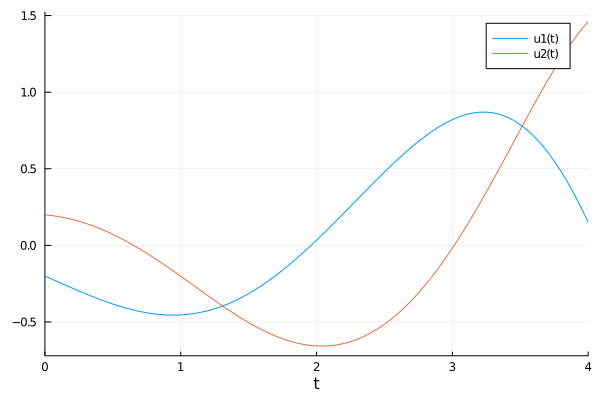

In [193]:
plot(sol_nn2)
#scatter(Array(sol_nn2)[1, :], Array(sol_nn2)[2, :])

## Test The Prediction

In [194]:
tspan_test = (0.0f0, 4.0f0)
u0 = Float32[-0.2, 0.2]
p_ = Float32[0.8, 1.2, 1.5]
prob_test = ODEProblem(Hopf2D, u0, tspan_test, p_)
solution_test = solve(prob_test, Vern7(), abstol=1e-12, reltol=1e-12, saveat = 0.05);

## Plot Toghether True And Prediction
### Phase Space Plot

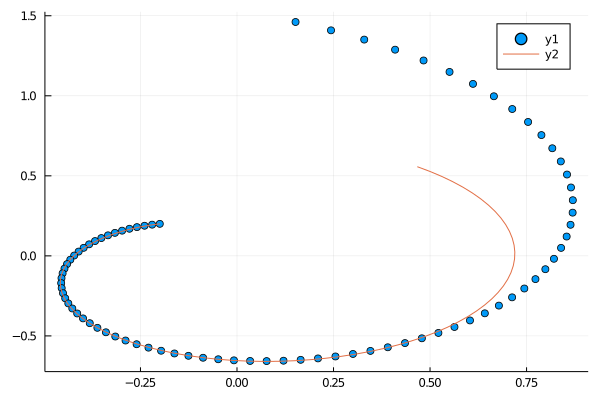

In [195]:
scatter(Array(sol_nn2)[1, :], Array(sol_nn2)[2, :])
plot!(Array(solution_test)[1, :], Array(solution_test)[2, :])

## Plot $x(t)$ and $y(t)$

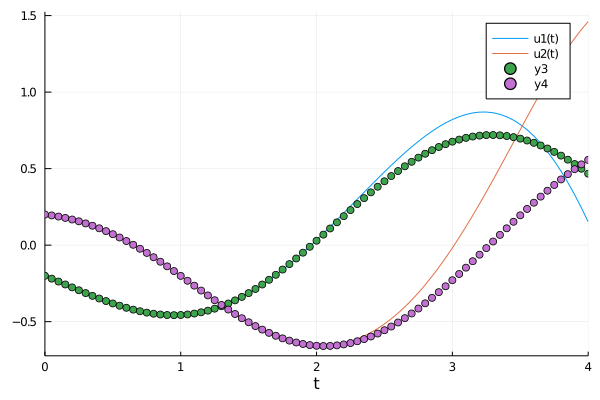

In [196]:
plot(sol_nn2)
scatter!(solution_test.t, Array(solution_test)[1, :])
scatter!(solution_test.t, Array(solution_test)[2, :])